In [1]:
'''
    Purpose: Apply LIME and SHAP on our ECG data, and generate explanations
    Model: CNN
    Data: 12 Lead ECG
'''

'\n    Purpose: Apply LIME and SHAP on our ECG data, and generate explanations\n    Model: CNN\n    Data: 12 Lead ECG\n'

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import gc
import itertools
import logging
from multiprocessing import Pool
import functools
import sys 
import random
from pathlib import Path
import time
import mlrose_ky as mlrose
#import mlrose
import h5py

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

# import ecg_analysis.data
# import ecg_analysis.classifier
import explainers_benchmarking as explainers

# Comlex_core wrappers
sys.path.append('/projectnb/peaclab-mon/JLi/projectx/CoMTE_V2_JLi/CoMTE_V2/comlex_core/src')  
# import project (wrapper) modules
from explainable_model_ECG import ClfModel as ClfModel
from explainable_data_ECG import ClfData as ClfData


import sys
sys.path.append('/projectnb/peaclab-mon/JLi/projectx/CoMTE_V2_JLi')
import datasets

2025-10-16 01:28:25.840843: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 01:28:25.940208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 01:28:25.955043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760592505.974634 1959417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760592506.009886 1959417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 01:28:26.119666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
# Select points to explain from testing set

# load testing dataset 
path_to_hdf5_test = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/CODE/ecg_tracings.hdf5"
dataset_name_test = "tracings"  

# Import data and create instance of class ECGSequence
seq = datasets.ECGSequence(path_to_hdf5_test, dataset_name_test)  # using default batch size

# load pretrained model (still need to compile later) 
model_path = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/PretrainedModels/model/model.hdf5"
pre_model = load_model(model_path)  

# compile and apply model to testing dataset
pre_model.compile(loss='binary_crossentropy', optimizer=Adam())

# predict
model_predictions = pre_model.predict(seq,verbose=1)   # y_score is a numpy array with dimensions 827x6. It holds the predictions generated by the model

# extra
print(model_predictions.shape)
print(model_predictions[:5])

# Generate dataframe
np.save("/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/dnn_output.npy", model_predictions)
print("Output predictions saved")

print(pre_model.input_shape)

W0000 00:00:1760592525.999145 1959417 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
(827, 6)
[[1.4243224e-06 1.0710077e-07 2.6336946e-07 4.5377445e-07 9.4853863e-07
  6.4135390e-09]
 [2.8897351e-02 2.0066681e-03 3.1778637e-01 2.8277384e-05 4.8343472e-02
  3.2049985e-04]
 [3.1124635e-04 2.9402861e-05 4.1752292e-06 1.9712777e-05 9.3489951e-03
  2.4932497e-05]
 [2.3969111e-09 1.7344941e-09 6.9393674e-10 8.1738605e-10 5.6821343e-09
  2.7672636e-10]
 [5.3062342e-04 3.5334501e-06 3.3941697e-07 1.4301397e-06 2.2422880e-04
  4.7077333e-06]]
Output predictions saved
(None, 4096, 12)


In [5]:
# using model without instance of ECGSeq

f = h5py.File(path_to_hdf5_test, "r")
timeseries = np.array(f[dataset_name_test])

print(timeseries.shape)

model_predictions = pre_model.predict(timeseries,verbose=1)   # y_score is a numpy array with dimensions 827x6. It holds the predictions generated by the model
print(model_predictions.shape)
print(model_predictions[:5])




(827, 4096, 12)
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step
(827, 6)
[[1.4243183e-06 1.0710037e-07 2.6337048e-07 4.5377399e-07 9.4853954e-07
  6.4135146e-09]
 [2.8897351e-02 2.0066681e-03 3.1778637e-01 2.8277358e-05 4.8343472e-02
  3.2050017e-04]
 [3.1124600e-04 2.9402892e-05 4.1752328e-06 1.9712761e-05 9.3489867e-03
  2.4932469e-05]
 [2.3969111e-09 1.7344908e-09 6.9393674e-10 8.1738760e-10 5.6821343e-09
  2.7672692e-10]
 [5.3062342e-04 3.5334501e-06 3.3941723e-07 1.4301370e-06 2.2422902e-04
  4.7077424e-06]]


In [6]:
def ECG_one_d_labels(model_predictions, onehot_labels = True):
    '''
    Purpose: turn one-hot encoding (N,d) array into (Nx1) vector of classes

    Input: 
    model_predictions: 2D array of probabilities or one-hot encodings (827x6)
    onehot_labels: boolean variable 

    Output: 
    (Nx1) vector of classes

    Comments: 
    The sample class is the class that exceeds the threshold
    If there are >1 classes that exceed the threshold, a tuple will be used to store the multiple classes 
    '''
    

    if not onehot_labels:
        # establish threshold
        threshold = np.array([0.124, 0.07, 0.05, 0.278, 0.390, 0.174])
        # generate class 0 probability
        exceedances = 1 - (np.maximum((model_predictions - threshold) , 0) / (1 - threshold))
        normal_prob = np.mean(exceedances, axis = 1, keepdims = True) # normal prob should be (N,1)
        # add normal prob
        probability_n = np.column_stack((normal_prob, model_predictions))
        # new threshold
        new_threshold = np.array([1, 0.124, 0.07, 0.05, 0.278, 0.390, 0.174])

        # make mask
        mask = probability_n >= new_threshold
    else:
        print(model_predictions.shape)

        mask = model_predictions == 1

        # Ensure each row has at least one '1'
        # no_positive_class is a column vector
        # Find rows with all False (no '1') # rows with all false becomes true
        no_positive_class = ~mask.any(axis=1) 
        
        # Expand mask by adding a new first column of zeros
        mask = np.column_stack((no_positive_class, mask))
    

    sample_classes = []
    for row in mask:
        passing_indices = np.where(row)[0]
        if len(passing_indices) > 1:  # If more than one indices pass
            if not onehot_labels: 
                # calc exceedances    
                exceedances = row - new_threshold
                # Get class with the highest exceedance
                max_class = np.argmax(exceedances)
                sample_classes.append(max_class)
            else:
                sample_classes.append(tuple(sorted(passing_indices)))  # Ensure passing indices are sorted in ascending order
        elif len(passing_indices) == 0:  # no passes
            sample_classes.append(0) 
        else:
            sample_classes.append(passing_indices[0])  

    return sample_classes


In [7]:
# load predictions to make y_pred
model_predictions = np.load("/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/dnn_output.npy")
# make y_pred
y_pred = ECG_one_d_labels(model_predictions, onehot_labels = False)

# make y_true
y_true_2D = pd.read_csv('/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/CODE/annotations/gold_standard.csv').values
# convert 2D to 1D
y_true = ECG_one_d_labels(y_true_2D, onehot_labels = True)

(827, 6)


In [8]:
# select indices/conditions for CoMTE
true_select = 0 #UPDATE HERE FOR OTHER CLASSES
pred_select = 0 #UPDATE HERE FOR OTHER CLASSES

# find relevant indices
indices_test = []
for idx, (true, pred) in enumerate(zip(y_true, y_pred)):
    print(f"Index:{idx}, True Label: {true}, Predicted Label: {pred}") # print elements
    if true ==  true_select and pred == pred_select:
        indices_test.append(idx)   
        
print('\n\n\n')
print(f"The {indices_test} indices match the case defined above:\n(true_select = {true_select}, pred_select = {pred_select})")

Index:0, True Label: 0, Predicted Label: 0
Index:1, True Label: 3, Predicted Label: 3
Index:2, True Label: 0, Predicted Label: 0
Index:3, True Label: 0, Predicted Label: 0
Index:4, True Label: 0, Predicted Label: 0
Index:5, True Label: 0, Predicted Label: 0
Index:6, True Label: 0, Predicted Label: 0
Index:7, True Label: 0, Predicted Label: 0
Index:8, True Label: 0, Predicted Label: 0
Index:9, True Label: 0, Predicted Label: 0
Index:10, True Label: 0, Predicted Label: 0
Index:11, True Label: 0, Predicted Label: 0
Index:12, True Label: 1, Predicted Label: 1
Index:13, True Label: 0, Predicted Label: 0
Index:14, True Label: 0, Predicted Label: 0
Index:15, True Label: (np.int64(1), np.int64(3)), Predicted Label: 3
Index:16, True Label: 0, Predicted Label: 0
Index:17, True Label: 0, Predicted Label: 0
Index:18, True Label: (np.int64(1), np.int64(3)), Predicted Label: 3
Index:19, True Label: 0, Predicted Label: 0
Index:20, True Label: 0, Predicted Label: 0
Index:21, True Label: 0, Predicted L

In [9]:
# For feature importance, create a dictionary

tp_indices = {
    1: [249, 420, 463],
    2: [106, 618, 683],
    3: [293, 1, 253],
    4: [495, 98, 188],
    5: [501, 572, 259],
    6: [492, 659, 767]
}

In [10]:
# select testing point

# get testing point
test_point = seq._getsample_(253)
# wrap test point 
test_df = ClfData.wrap_df_test_point(test_point)

print(test_df.shape)

(4096, 12)


In [11]:
# load data 

# load in train and test sets, define key variables
class BasicData:
    # define basic variables
    classes_available = [0,1,2,3,4,5,6]
    num_columns = 4096
    num_features = 12

    # define key paths and variables for training data
    path_to_hdf5_test = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/CODE/ecg_tracings.hdf5"
    dataset_name_hdf_tracings = "tracings" 
    training_set_hdf_path = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/combined_V2.hdf5"
    y_train_csv_path = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/labels_combined_V2.csv"
    
    f = h5py.File(training_set_hdf_path, "r")
    timeseries = np.array(f[dataset_name_hdf_tracings])

    # iterable of corresponding labels for the samples for the data wrapper (returns 20000x6 np array) <--- take out first column that represents ExamID
    labels = pd.read_csv(y_train_csv_path)


In [12]:
"""
Model wrapper for SHAP
"""

class BasicClassifier:
    classifier = pre_model  # tensorflow CNN
    import os
    
    @staticmethod
    def contrived_classification(pandas_dfs):
        """
        Notes: 
            if there were multiple classes that exceeded the threshold, the class with the highest exceedance was assigned
            to the sample

        Input: 
            numpy_df: pandas multiindex array of samples

        Output: 
            if there is one sample: function returns the index
            if there are multiple samples: function returns a (1xN) list of the indices
        """
        classifier = pre_model  # tensorflow CNN
        
        # create instance of ECGSequence to store the (N,4096,12) dataset
        temp_path = "/projectnb/peaclab-mon/JLi/projectx/AutoECGDiagnosisData/temporary.hdf5"
        temp_dataset_name = "tracings"
        if os.path.exists(temp_path):
            os.remove(temp_path)
        # create hdf with appropriate data
        hdf_file = h5py.File(temp_path, 'w')
        hdf_file.create_dataset(temp_dataset_name,data = array_3d)
        # init instnace of ECG Sequence holding modified with hdf path
        modified_instance = datasets.ECGSequence(temp_path, temp_dataset_name)
        # get classification and probability
        probability = classifier.predict(modified_instance, verbose = 1)    
        # close hdf5's
        modified_instance._closehdf()
        hdf_file.close()
        os.remove(temp_path)
        # analyze model output with thresholding
        # define given thresholds
        threshold = np.array([0.124, 0.07, 0.05, 0.278, 0.390, 0.174])
        
        # generate class 0 probability
        exceedances = 1 - (np.maximum((probability - threshold) , 0) / (1 - threshold))
        normal_prob = np.mean(exceedances, axis = 1, keepdims = True) # normal prob should be (N,1)
        
        # Add normal_prob as a new column
        probability_n = np.column_stack((normal_prob, probability))     

        # new threshold
        new_threshold = np.array([1, 0.124, 0.07, 0.05, 0.278, 0.390, 0.174])
        
        mask = probability_n >= new_threshold
        sample_classes = []
        
        for row, mask in zip(probability_n, mask):
            passing_indices = np.where(mask)[0]
            if len(passing_indices) > 1:  # If more than one indices pass
                # compute exceedance
                exceedances = row[passing_indices] - new_threshold[passing_indices]
                # Get class with the highest exceedance
                max_class = passing_indices[np.argmax(exceedances)]
                sample_classes.append(max_class)
            elif len(passing_indices) == 0:  # no passes
                sample_classes.append(0) 
            else:
                sample_classes.append(passing_indices[0])  
                
        # don't return list if only one sample
        if len(sample_classes) == 1:
            sample_classes = sample_classes[0]
        
        return sample_classes 
        

    # LIME prediction function...
    def contrived_classification_proba_LIME(np_2d_array):
        import os
        """
        Purpose: 
            make prediction and return set of probabilities
        Return: 
            if there are single or multiple samples: function returns a list of arrays containing the probabilities
        """

        # reshape
        num_features = np_2d_array.shape[0]
        print(f"num features is {num_features}")
        df_reshaped = np_2d_array.reshape(num_features, 4096, 12)

        # init classifier
        classifier = pre_model  # tensorflow CNN

        # get classification and probability
        probability = classifier.predict(df_reshaped, verbose = 1)  
        
        return probability

In [13]:
"""
Part 3: Wrapping it up.

The training data, training labels, and trained classifier need to be wrapped up
into a form that can pass through COMLEX.

While wrapping up the training data and labels is relatively straightforward,
wrapping up the classifier is more difficult

Pipeline:
input: Raw ECG data (pandas multiindex array). 
output: classification from random forest model (class number)

Note: Ensure inputs/outputs are identical with the input/output for CoMTE classification algorithm, so we can just use this pipeline as a direct replacement

"""

class BasicComlexInput:
    sample_number = 253
    
    classifier = pre_model  # tensorflow CNN

    # wrap training points for SHAP
    df_train_points_SHAP = ClfData.wrap_df_x_SHAP(BasicData.timeseries, BasicData.num_features)

    # wrap training points for LIME (default C-Style flattening used)
    df_train_points_LIME = ClfData.wrap_df_x_LIME(BasicData.timeseries, BasicData.num_features)
    
    # wrap training labels 
    df_train_labels = ClfData.wrap_df_y(BasicData.labels)

    
    # select test point 
    test_point = seq._getsample_(sample_number)
    
    # wrap test point for SHAP
    test_df_SHAP = ClfData.wrap_df_test_point_SHAP(test_point)

    # wrap test point for LIME (row major flattening)
    test_df_LIME = ClfData.wrap_df_test_point_LIME(test_point)

    # wrap classifier for LIME
    wrapped_classifier_LIME = ClfModel(BasicClassifier.classifier,
                                predict_attr=BasicClassifier.contrived_classification,
                                predict_proba_attr=BasicClassifier.contrived_classification_proba_LIME,
                                column_attr=['DI','DII','DIII','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'],
                                classes_attr=BasicData.classes_available,
                                window_size_attr=BasicData.num_columns)

<class 'numpy.ndarray'>
Cutting out the first 20 features
timeseries shape is (20000, 4096, 12)
<class 'numpy.ndarray'>
Cutting out the first 100 features
timeseries shape is (20000, 4096, 12)
Final shape after flattening: (100, 49152)
(20000, 6)
(20000, 6)
(20000,)
(20000, 7)
sample shape for SHAP is (1, 4096, 12)
initial sample shape for lime is (1, 4096, 12)
final is: (1, 49152)


In [14]:
# VALIDATION: ensure data transformations yield the same probabilities

testing_dat = BasicComlexInput.df_train_points_LIME
preds1 = BasicComlexInput.wrapped_classifier_LIME.predict_proba(testing_dat)
print(preds1)

print('\n\n\n\n')

testing_dat_shap = BasicComlexInput.df_train_points_SHAP
preds2 = BasicComlexInput.classifier.predict(testing_dat_shap)
print(preds2)


# unit test

num features is 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step 
[[1.16907708e-01 4.66498523e-06 8.22540733e-06 3.56280099e-04
  7.79340789e-03 1.18388087e-01]
 [6.21127811e-06 2.57335432e-06 1.28300258e-07 1.20335798e-07
  1.01114292e-05 1.29563693e-08]
 [1.36062430e-04 6.98987776e-07 1.42848767e-05 1.51076179e-07
  1.95670618e-05 1.07405431e-05]
 [4.47422417e-06 7.34584000e-06 1.24435900e-07 8.36479070e-04
  3.45889617e-07 7.10541181e-09]
 [1.44566957e-06 5.65839713e-08 5.11142915e-08 5.74436632e-09
  3.13566625e-06 2.75343108e-08]
 [1.10292854e-03 5.57419844e-04 4.78806687e-05 2.15810314e-06
  9.36442673e-01 1.37089655e-05]
 [1.31754923e-05 1.82417761e-08 2.79290813e-09 1.51449324e-08
  2.06939112e-05 2.02230112e-07]
 [9.60164834e-05 8.95651829e-06 8.19058073e-07 4.70095029e-06
  2.29502393e-06 8.15026624e-09]
 [1.56319437e-08 2.91670965e-10 1.96344330e-11 8.03052624e-11
  3.62724828e-09 3.81311961e-11]
 [3.15862344e-05 9.67222331e-06 3.32661301e-07 6.24741707e-03
  6.99977909e-06 2.15371

In [15]:

def test_lime_and_shap_predictions_match(BasicComlexInput, tol=1e-6):
    """
    Validate that the LIME and SHAP data transformations produce
    the same probability predictions from the classifier.
    """
    # Run predictions on LIME-transformed data
    testing_dat_lime = BasicComlexInput.df_train_points_LIME[:20,:]
    preds_lime = BasicComlexInput.wrapped_classifier_LIME.predict_proba(testing_dat_lime)

    # Run predictions on SHAP-transformed data
    testing_dat_shap = BasicComlexInput.df_train_points_SHAP
    preds_shap = BasicComlexInput.classifier.predict(testing_dat_shap)

    # Ensure shape is the same
    assert preds_lime.shape == preds_shap.shape, (
        f"Prediction shapes differ: {preds_lime.shape} vs {preds_shap.shape}"
    )

    # Ensure probabilities are numerically close
    assert np.allclose(preds_lime, preds_shap, atol=tol), (
        f"Predictions differ more than tolerance {tol}"
    )


# run unit test
test_lime_and_shap_predictions_match(BasicComlexInput)

num features is 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


## Apply SHAP

In [16]:
import shap

'''
    Inputs: 
    1. Raw CNN
    2. (20,4096,12) training data tensor 

    Paper for reference: https://www.sciencedirect.com/science/article/pii/S1746809422001069 
'''

# X_train_background is typically a small representative subset of X_train
#BasicComlexInput.df_train_points_SHAP.shape

# init shap explainer
explainer = shap.GradientExplainer(BasicClassifier.classifier, BasicComlexInput.df_train_points_SHAP)

In [17]:
print(BasicComlexInput.df_train_points_SHAP.shape)

(20, 4096, 12)


In [18]:
# get shap value
# shap_values = explainer.shap_values(BasicComlexInput.test_df_SHAP)
# print(shap_values)
shap_values = explainer(BasicComlexInput.test_df_SHAP)

In [19]:
shap_values.values.shape

print(type(shap_values.values))
print(shap_values.shape)
shap_values_np = shap_values.values 

np.save(f"./lime_shap_explanations/sample{BasicComlexInput.sample_number}_shap.npy", shap_values_np)

<class 'numpy.ndarray'>
(1, 4096, 12, 6)


0


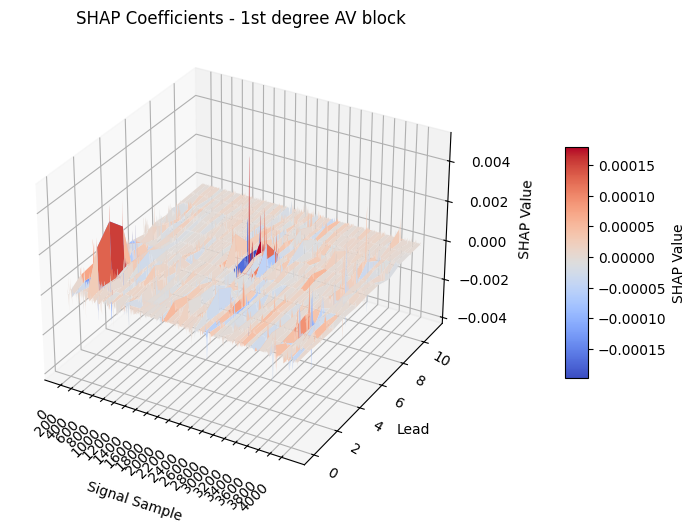

1


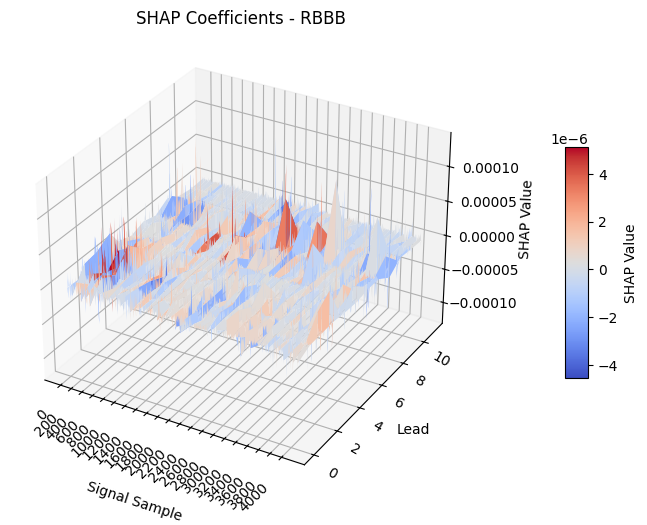

2


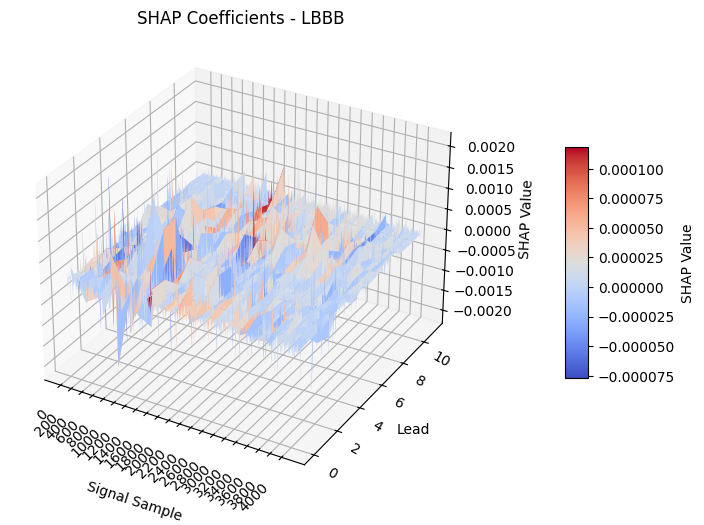

3


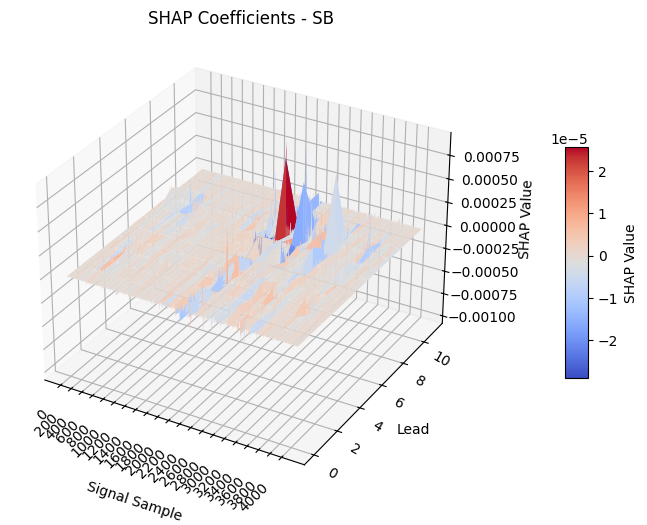

4


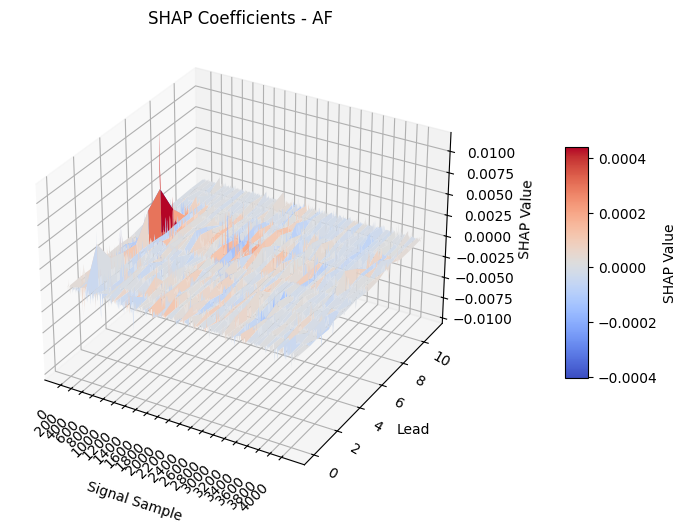

5


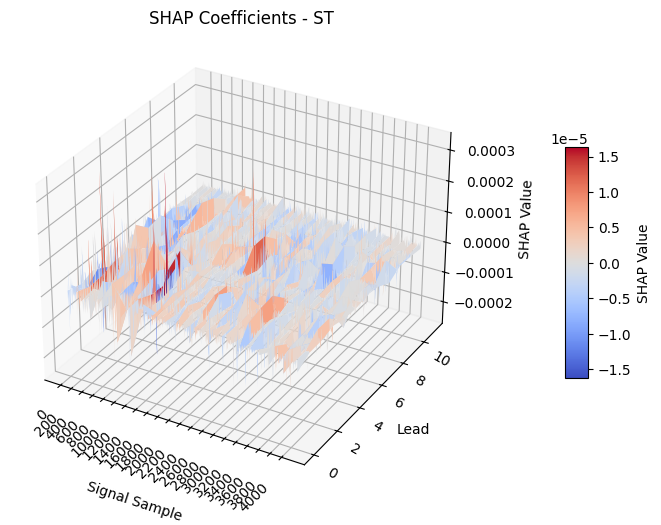

In [20]:
# SHAP Visualization

# waterfall and beeswarm plots are unrealistic since they require 1D inputs`
# shap.plots.waterfall(shap_values[0])

save_dir = "./LIME_SHAP_visualizations"

# visualize with 2D heatmap (one heatmap per class)
import matplotlib.pyplot as plt
import seaborn as sns
import os

class_list = ['1st degree AV block', 'RBBB','LBBB','SB','AF','ST']

for i in range(shap_values.values.shape[3]):
    print(i)
    shap_map = shap_values.values[0,:,:,i]

    # # plot heatmap
    # plt.figure(figsize=(12,6))
    # sns.heatmap(shap_map.T, cmap="coolwarm", center=0, 
    #             xticklabels=False,  # hide all 4096 ticks
    #             yticklabels=[f"Lead {i}" for i in range(12)])
    # plt.title(f"SHAP 2D Heatmap - Class {i}")
    # plt.xlabel("Time")
    # plt.ylabel("ECG Lead")
    # plt.show()
    # # save figure
    # heatmap_path = os.path.join(save_dir, f"shap_heatmap_class_{i}.png")
    # # fig.savefig(heatmap_path, dpi=300, bbox_inches="tight")
    # # plt.close(fig)
    
    
    # plot surface 
    time = np.arange(shap_map.shape[0])
    leads = np.arange(shap_map.shape[1])
    X, Y = np.meshgrid(time, leads)
    
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(X, Y, shap_map.T)
    surf = ax.plot_surface(X, Y, shap_map.T, cmap="coolwarm")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10,pad=0.1, label="SHAP Value")
    
    ax.set_xticks(np.arange(0, shap_map.shape[0], step=200))
    ax.set_yticks(np.arange(0, shap_map.shape[1], step=2))
    
    # rotate X
    for label in ax.get_xticklabels():
        label.set_rotation(45)    # try 30, 45, or 60 degrees
        label.set_ha('right')     # align nicely

    # Rotate Y axis tick labels
    for label in ax.get_yticklabels():
        label.set_rotation(-30)   # tilt the other way for readability
        label.set_va('center')

    ax.zaxis.set_tick_params(pad=10)  # move Z tick labels further away

    
    ax.set_title(f"SHAP Coefficients - {class_list[i]}")
    ax.set_xlabel("Signal Sample", labelpad = 20)
    ax.set_ylabel("Lead")
    ax.set_zlabel("SHAP Value", labelpad = 15)
    plt.show()

    # save figure
    surface_path = os.path.join(save_dir, f"shap_surface_class_{class_list[i]}.png")
    fig.savefig(surface_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    

In [21]:
# shap_values.shape

# # select shap values for a particular disease
# selected_index = 0
# shap_values_index = shap_values[:,:,:,selected_index][0]

# # print stats
# print(shap_values_index.shape)
# print(f'minimum shap value is: {np.min(shap_values_index)}')
# print(f'maximum shap value is: {np.max(shap_values_index)}')

## Apply LIME

In [22]:
import lime
import lime.lime_tabular as limetabular

# instantiate LIME tabular explainer


'''
    input: 
    1. flattened data (N,49152) <-- flattened in row-major order (C-style)
    2. model
    3. feature names 
    4. classification
'''

LIME_explainer = limetabular.LimeTabularExplainer(BasicComlexInput.df_train_points_LIME, 
                                                  mode = 'classification')

In [23]:
print(BasicComlexInput.test_df_LIME.flatten().shape)
print(BasicComlexInput.test_df_LIME.shape)
print(BasicComlexInput.test_df_LIME.size)

(49152,)
(1, 49152)
49152


In [35]:
# generate explainer

'''
    Note: we will not be explaining the normal class

    The probabilities returned by the CNN will be for diseased states only
'''

explanation = LIME_explainer.explain_instance(
    BasicComlexInput.test_df_LIME.flatten(),
    predict_fn=BasicComlexInput.wrapped_classifier_LIME.predict_proba,
    num_features=BasicComlexInput.test_df_LIME.size)

num features is 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step


In [38]:
label_to_explain = 1

# generate array of explanations
print(type(explanation.as_map()))
print(explanation.as_map().keys())
print(list(explanation.as_map().keys()))
print(explanation.class_names)


feature_weights = explanation.as_map()[label_to_explain]  # list of (index, weight)

# Initialize array of zeros for *all* features
num_features = BasicComlexInput.test_df_LIME.size
coeffs_flat = np.zeros(num_features)

# Fill in LIME coefficients for explained features
for idx, weight in feature_weights:
    coeffs_flat[idx] = weight

# Reshape back to original shape with row-major reshaping
coeffs_matrix = coeffs_flat.reshape(4096, 12)

print("Shape:", coeffs_matrix.shape)
print(coeffs_matrix)


# Save off
np.save(f"./lime_shap_explanations/sample{BasicComlexInput.sample_number}_class{label_to_explain}_lime.npy", coeffs_matrix)



# # generate list of explanations
# exp_list = explanation.as_list(label=label_to_explain)
# print(exp_list)

# # generate barchart
# explanation.as_pyplot_figure(label=label_to_explain)
# plt.title("LIME Coefficients for 1st degree AV block")   # change title
# # save barchart
# surface_path = os.path.join(save_dir, f"lime_barchart.png")
# plt.savefig(surface_path, dpi=300, bbox_inches="tight")
# plt.show()

# # generate all coefficients


<class 'dict'>
dict_keys([1])
[1]
['0', '1', '2', '3', '4', '5']
Shape: (4096, 12)
[[ 7.44123959e-07  1.80566243e-06  1.66013343e-06 ... -2.41692336e-06
  -4.71788689e-07  4.93093356e-07]
 [-7.33434762e-07 -1.77101725e-07 -2.96688242e-08 ... -1.65862038e-07
   1.81940968e-07 -1.71662938e-06]
 [-1.23111972e-06 -1.20172641e-06 -1.76509540e-07 ...  3.93060134e-07
   1.30036575e-06 -1.59631010e-06]
 ...
 [-3.51293309e-06  2.95308060e-06 -6.99085324e-07 ...  2.68714885e-06
  -1.81582033e-06 -4.74464930e-07]
 [-5.43843705e-07 -3.26371629e-07  9.13363939e-07 ...  2.40141940e-06
   4.03035797e-07  3.16380999e-07]
 [-3.31074906e-06  1.95323694e-06  9.03507118e-07 ...  9.78168452e-07
  -1.78715483e-06 -3.01459971e-06]]


In [ ]:
## Feature Importance Experiment: Running SHAP and LIME
tp_indices = {
    1: [249, 420, 463],
    2: [106, 618, 683],
    3: [293, 1, 253],
    4: [495, 98, 188],
    5: [501, 572, 259],
    6: [492, 659, 767]
}

for key, value in tp_indices.items():
    for sample_num in value: 
        print(f"Sample: {sample_num}")
        
        # process testing data
        test_point = seq._getsample_(sample_num)
        # wrap test point for SHAP
        test_df_SHAP = ClfData.wrap_df_test_point_SHAP(test_point)
        # wrap test point for LIME (row major flattening)
        test_df_LIME = ClfData.wrap_df_test_point_LIME(test_point)

        # run shap
        print('running shap')
        shap_values = explainer(test_df_SHAP)
        print(f"pre slice shape: {shap_values.shape}")
        shap_values_sliced = shap_values[:, :, :, key-1]
        print(f"slicing {key-1}th layer")
        print(f"post slice shape: {shap_values_sliced.shape}")
        np.save(f"./lime_shap_explanations/sample{sample_num}_class{key}_shap_.npy", shap_values_sliced)
        
        # run lime
        print('running lime')
        lime_explanation = LIME_explainer.explain_instance(
        test_df_LIME.flatten(),
        predict_fn=BasicComlexInput.wrapped_classifier_LIME.predict_proba,
        num_features=test_df_LIME.size)
        # generate array of explanations
        # print(explanation.as_map())
        # print(type(explanation.as_map()))
        feature_weights = explanation.as_map()[1]    # lime by default only explains the predicted class
        print(feature_weights[:3])
        # Initialize array of zeros for all features
        num_features = BasicComlexInput.test_df_LIME.size
        coeffs_flat = np.zeros(num_features)
        # Fill in LIME coefficients for explained features
        for idx, weight in feature_weights:
            coeffs_flat[idx] = weight
        # Reshape back to original shape with row-major reshaping
        coeffs_matrix = coeffs_flat.reshape(4096, 12)
        print("coef matrix shape:", coeffs_matrix.shape)
        print(coeffs_matrix)
        # Save off
        np.save(f"./lime_shap_explanations/sample{sample_num}_class{key}_lime.npy", coeffs_matrix)

Sample: 249
sample shape for SHAP is (1, 4096, 12)
initial sample shape for lime is (1, 4096, 12)
final is: (1, 49152)
running shap
pre slice shape: (1, 4096, 12, 6)
slicing 0th layer
post slice shape: (1, 4096, 12)
running lime
num features is 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step
{1: [(np.int64(39083), np.float64(9.195120766557374e-06)), (np.int64(37117), np.float64(8.6313212450556e-06)), (np.int64(7862), np.float64(8.464610471292462e-06)), (np.int64(11955), np.float64(-8.395477677181423e-06)), (np.int64(13728), np.float64(8.274234106973201e-06)), (np.int64(41275), np.float64(8.101471966453884e-06)), (np.int64(21666), np.float64(-7.517825010881e-06)), (np.int64(43942), np.float64(-7.513488148319052e-06)), (np.int64(28781), np.float64(7.4771288402938395e-06)), (np.int64(41906), np.float64(-7.460805848660739e-06)), (np.int64(9926), np.float64(7.368053313904701e-06)), (np.int64(19552), np.float64(-7.366429890150977e-06)), (np.int64(46281), np.float64(7.187385556300656e-06)), 